Checking environment...
Training prediction models...

--- ANALYZING LOCATION: 24327 se 42nd st, issaquah,wa-98029 ---
Could not find address. Defaulting to Sammamish, WA.


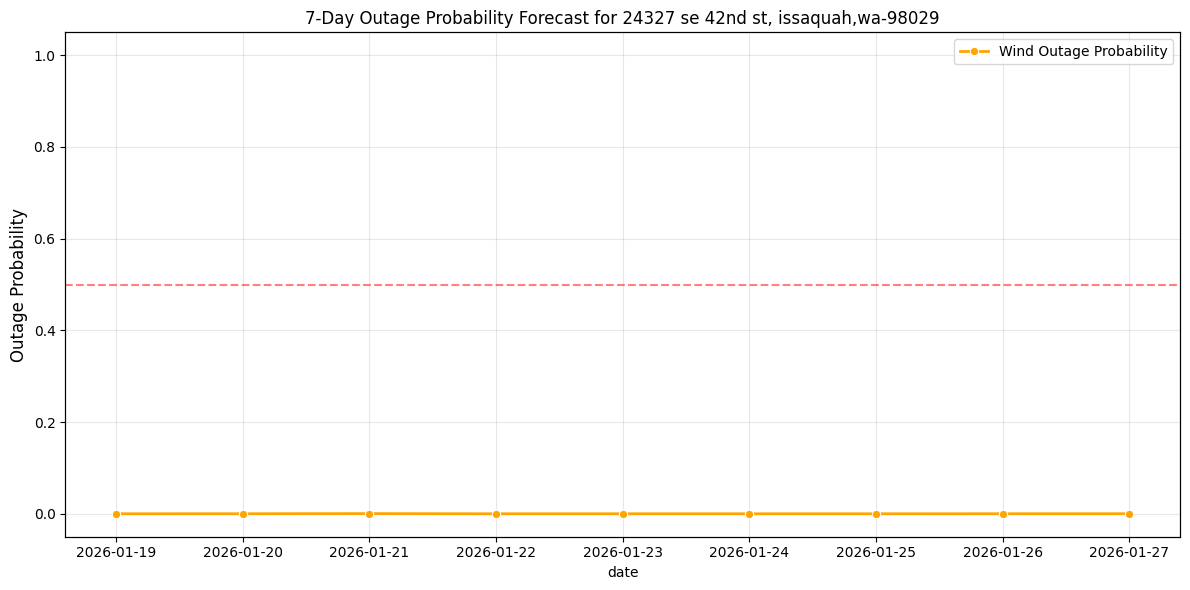


--- 7-DAY FORECAST SUMMARY ---
      date            Status
2026-01-19 Safe (Wind: 0.00)
2026-01-20 Safe (Wind: 0.00)
2026-01-21 Safe (Wind: 0.00)
2026-01-22 Safe (Wind: 0.00)
2026-01-23 Safe (Wind: 0.00)
2026-01-24 Safe (Wind: 0.00)
2026-01-25 Safe (Wind: 0.00)
2026-01-26 Safe (Wind: 0.00)
2026-01-27 Safe (Wind: 0.00)


In [8]:
# @title ⚡ 7-Day Power Outage Forecast
# @markdown Enter your address below and click the **Run** button (▶️) to generate a live risk assessment.

import subprocess
import sys
import os
import warnings
import pandas as pd
import numpy as np
import requests
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
from datetime import datetime, timedelta
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

warnings.filterwarnings('ignore')

# --- USER INPUT ---
Address = "24327 se 42nd st, issaquah,wa-98029" # @param {type:"string"}

if Address:
    # --- 1. SETUP & INSTALLATION ---
    def install(package):
        subprocess.check_call([sys.executable, "-m", "pip", "install", package])

    print("Checking environment...")
    try:
        import openmeteo_requests
        import requests_cache
        from retry_requests import retry
        from imblearn.over_sampling import SMOTE
    except ImportError:
        print("Installing necessary libraries (this may take a moment)...")
        install("openmeteo_requests")
        install("requests-cache")
        install("retry-requests")
        install("imbalanced-learn")
        import openmeteo_requests
        import requests_cache
        from retry_requests import retry
        from imblearn.over_sampling import SMOTE

    # --- 2. DATA GENERATION ---
    HISTORICAL_FILE = 'sammamish_complete_features.csv'

    # Hardcoded outage events (Ground Truth)
    outage_events = {
        '2024-11-19': 1, '2024-11-20': 1, '2021-10-24': 1, '2021-01-13': 1,
        '2021-11-15': 1, '2022-11-04': 1, '2025-10-25': 1, '2022-12-26': 1,
        '2021-10-25': 1, '2025-07-20': 1, '2020-08-10': 1, '2025-02-25': 1,
        '2022-12-23': 2, '2024-01-12': 2, '2024-01-13': 2, '2024-01-14': 2,
        '2021-02-13': 2
    }

    def generate_historical_data():
        print("Fetching historical weather data for model training...")
        cache_session = requests_cache.CachedSession('.cache', expire_after=3600)
        retry_session = retry(cache_session, retries=5, backoff_factor=0.2)
        openmeteo = openmeteo_requests.Client(session=retry_session)

        lat, lon = 47.58, -122.03
        url = "https://archive-api.open-meteo.com/v1/archive"

        # Use a fixed safe end date to avoid future request errors (API 500s)
        end_date_hist = "2024-12-30"

        params = {
            "latitude": lat, "longitude": lon,
            "start_date": "2021-01-01", "end_date": end_date_hist,
            "hourly": ["temperature_2m", "precipitation", "rain", "snowfall", "snow_depth",
                       "wind_speed_10m", "wind_gusts_10m",
                       "soil_moisture_0_to_7cm", "soil_moisture_7_to_28cm"],
            "timezone": "America/Los_Angeles"
        }

        responses = openmeteo.weather_api(url, params=params)
        hourly = responses[0].Hourly()

        hourly_data = {"date": pd.date_range(
            start=pd.to_datetime(hourly.Time(), unit="s", utc=True),
            end=pd.to_datetime(hourly.TimeEnd(), unit="s", utc=True),
            freq=pd.Timedelta(seconds=hourly.Interval()),
            inclusive="left"
        )}

        hourly_data["temp"] = hourly.Variables(0).ValuesAsNumpy()
        hourly_data["precip"] = hourly.Variables(1).ValuesAsNumpy()
        hourly_data["rain"] = hourly.Variables(2).ValuesAsNumpy()
        hourly_data["snow"] = hourly.Variables(3).ValuesAsNumpy()
        hourly_data["snow_depth"] = hourly.Variables(4).ValuesAsNumpy()
        hourly_data["wind_speed"] = hourly.Variables(5).ValuesAsNumpy()
        hourly_data["wind_gust"] = hourly.Variables(6).ValuesAsNumpy()
        hourly_data["soil_surface"] = hourly.Variables(7).ValuesAsNumpy()
        hourly_data["soil_deep"] = hourly.Variables(8).ValuesAsNumpy()

        df = pd.DataFrame(data=hourly_data)

        # Aggregate to Daily
        df_daily = df.set_index('date').resample('D').agg({
            'temp': ['min', 'max', 'mean'],
            'wind_speed': 'mean',
            'wind_gust': 'max',
            'rain': 'sum',
            'snow': 'sum',
            'snow_depth': 'max',
            'soil_surface': 'mean',
            'soil_deep': 'mean'
        })
        df_daily.columns = ['_'.join(col).strip() for col in df_daily.columns.values]

        # Map Targets
        df_daily['OutageType'] = 0
        for date_str, o_type in outage_events.items():
            dt = pd.to_datetime(date_str).tz_localize('UTC')
            # Only map if date exists in our fetched range
            if dt in df_daily.index:
                match_idx = df_daily.index.get_indexer([dt], method='nearest')[0]
                if abs(df_daily.index[match_idx] - dt) < pd.Timedelta(days=1):
                     df_daily.iloc[match_idx, df_daily.columns.get_loc('OutageType')] = o_type
            else:
                # If the event is outside our range (e.g. future 2025 events), skip
                pass

        return df_daily

    # Load or Generate Data
    # Force regeneration to fix the error if the file exists but is partial/bad
    if os.path.exists(HISTORICAL_FILE):
        try:
            df_hist = pd.read_csv(HISTORICAL_FILE, index_col=0)
            df_hist.index = pd.to_datetime(df_hist.index)
        except:
            df_hist = generate_historical_data()
            df_hist.to_csv(HISTORICAL_FILE)
    else:
        df_hist = generate_historical_data()
        df_hist.to_csv(HISTORICAL_FILE)

    df_hist = df_hist.fillna(0)
    df_hist['IsWindOutage'] = (df_hist['OutageType'] == 1).astype(int)
    df_hist['IsSnowOutage'] = (df_hist['OutageType'] == 2).astype(int)

    # --- 3. MODEL TRAINING ---
    print("Training prediction models...")

    wind_features = ['wind_gust_max', 'soil_deep_mean', 'rain_sum']
    snow_features = ['wind_gust_max', 'soil_deep_mean', 'temp_min', 'snow_sum', 'rain_sum']

    # Wind Model
    X_wind = df_hist[wind_features]
    y_wind = df_hist['IsWindOutage']
    model_wind = LogisticRegression(class_weight='balanced', random_state=42)
    model_wind.fit(X_wind, y_wind)

    # Snow Model
    X_snow = df_hist[snow_features]
    y_snow = df_hist['IsSnowOutage']

    if y_snow.sum() > 1:
        smote = SMOTE(k_neighbors=1, random_state=42)
        X_snow_res, y_snow_res = smote.fit_resample(X_snow, y_snow)
        model_snow = LogisticRegression(random_state=42)
        model_snow.fit(X_snow_res, y_snow_res)
    else:
        model_snow = LogisticRegression(class_weight='balanced', random_state=42)
        model_snow.fit(X_snow, y_snow)

    # --- 4. LIVE INFERENCE ---
    def get_coordinates(address):
        url = f"https://nominatim.openstreetmap.org/search?format=json&q={requests.utils.quote(address)}"
        headers = {"User-Agent": "ColabOutagePredictor/1.0"}
        try:
            r = requests.get(url, headers=headers, timeout=10)
            if r.status_code == 200 and len(r.json()) > 0:
                return float(r.json()[0]['lat']), float(r.json()[0]['lon'])
        except:
            pass
        return None, None

    print(f"\n--- ANALYZING LOCATION: {Address} ---")
    lat, lon = get_coordinates(Address)

    if lat is None:
        print("Could not find address. Defaulting to Sammamish, WA.")
        lat, lon = 47.58, -122.03
    else:
        print(f"Coordinates found: {lat:.4f}, {lon:.4f}")

    # Fetch Forecast
    cache_session = requests_cache.CachedSession('.cache', expire_after=3600)
    retry_session = retry(cache_session, retries=5, backoff_factor=0.2)
    openmeteo = openmeteo_requests.Client(session=retry_session)

    url_fc = "https://api.open-meteo.com/v1/forecast"
    today = datetime.now()
    end_date = today + timedelta(days=7)
    params_fc = {
        "latitude": lat, "longitude": lon,
        "start_date": today.strftime('%Y-%m-%d'),
        "end_date": end_date.strftime('%Y-%m-%d'),
        "hourly": ["temperature_2m", "rain", "snowfall", "wind_gusts_10m", "soil_moisture_7_to_28cm"],
        "timezone": "America/Los_Angeles"
    }

    responses = openmeteo.weather_api(url_fc, params=params_fc)
    hourly_fc = responses[0].Hourly()

    fc_data = {"date": pd.date_range(
        start=pd.to_datetime(hourly_fc.Time(), unit="s", utc=True),
        end=pd.to_datetime(hourly_fc.TimeEnd(), unit="s", utc=True),
        freq=pd.Timedelta(seconds=hourly_fc.Interval()),
        inclusive="left"
    )}
    fc_data["temp_min"] = hourly_fc.Variables(0).ValuesAsNumpy()
    fc_data["rain_sum"] = hourly_fc.Variables(1).ValuesAsNumpy()
    fc_data["snow_sum"] = hourly_fc.Variables(2).ValuesAsNumpy()
    fc_data["wind_gust_max"] = hourly_fc.Variables(3).ValuesAsNumpy()
    fc_data["soil_deep_mean"] = hourly_fc.Variables(4).ValuesAsNumpy()

    df_fc = pd.DataFrame(data=fc_data)
    df_fc_daily = df_fc.set_index('date').resample('D').agg({
        'temp_min': 'min', 'rain_sum': 'sum', 'snow_sum': 'sum',
        'wind_gust_max': 'max', 'soil_deep_mean': 'mean'
    })

    if df_fc_daily['soil_deep_mean'].isnull().any():
        hist_soil_mean = df_hist['soil_deep_mean'].mean()
        df_fc_daily['soil_deep_mean'] = df_fc_daily['soil_deep_mean'].fillna(hist_soil_mean)

    # Predictions
    df_fc_daily['PredWind'] = model_wind.predict(df_fc_daily[wind_features])
    df_fc_daily['PredWindProb'] = model_wind.predict_proba(df_fc_daily[wind_features])[:, 1]

    df_fc_daily['PredSnow'] = model_snow.predict(df_fc_daily[snow_features])
    df_fc_daily['PredSnowProb'] = model_snow.predict_proba(df_fc_daily[snow_features])[:, 1]

    # --- 5. VISUALIZATION ---
    fig, ax1 = plt.subplots(figsize=(12, 6))
    plot_data = df_fc_daily.reset_index()
    plot_data['date'] = plot_data['date'].dt.date

    # Plot Probabilities instead of Wind Gust
    sns.lineplot(data=plot_data, x='date', y='PredWindProb', ax=ax1, color='orange', marker='o', label='Wind Outage Probability', linewidth=2)
    # Removed snow outage line as requested
    # sns.lineplot(data=plot_data, x='date', y='PredSnowProb', ax=ax1, color='teal', marker='s', linestyle='--', label='Snow Outage Probability', linewidth=2)

    ax1.set_ylabel('Outage Probability', color='black', fontsize=12)
    ax1.set_ylim(-0.05, 1.05)
    ax1.axhline(y=0.5, color='red', linestyle='--', alpha=0.5, label='Decision Threshold (0.5)')

    # Keep snow accumulation on secondary axis for context
    ax2 = ax1.twinx()
    if plot_data['snow_sum'].sum() > 0:
        ax2.bar(plot_data['date'], plot_data['snow_sum'], color='skyblue', alpha=0.2, label='Snow Accumulation (cm)')
        ax2.set_ylabel('Snow Accumulation (cm)', color='steelblue', fontsize=12)
    else:
        ax2.set_yticks([])

    # Highlights
    ymin, ymax = ax1.get_ylim()
    for i, row in plot_data.iterrows():
        if row['PredWind'] == 1:
            ax1.axvspan(row['date'], row['date'] + timedelta(days=1), color='gold', alpha=0.3)
            ax1.text(row['date'], 0.95, 'WIND RISK', color='darkgoldenrod', ha='center', fontweight='bold')
        # Removed snow outage highlights as requested
        # if row['PredSnow'] == 1:
        #     ax1.axvspan(row['date'], row['date'] + timedelta(days=1), color='cyan', alpha=0.3)
        #     ax1.text(row['date'], 0.85, 'SNOW RISK', color='teal', ha='center', fontweight='bold')

    ax1.set_title(f"7-Day Outage Probability Forecast for {Address}")
    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    ax1.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    # --- 6. SUMMARY ---
    print("\n--- 7-DAY FORECAST SUMMARY ---")
    summary = df_fc_daily.reset_index()[['date', 'PredWind', 'PredWindProb', 'PredSnow', 'PredSnowProb']]
    summary['date'] = summary['date'].dt.date
    def get_status(row):
        # Modified summary to deprioritize snow status in display logic or keep as is since graph was requested.
        # Keeping as is for now unless user asks to remove from summary table too.
        if row['PredSnow'] == 1: return f"SNOW OUTAGE (Risk: {row['PredSnowProb']:.2f})"
        if row['PredWind'] == 1: return f"WIND OUTAGE (Risk: {row['PredWindProb']:.2f})"
        return f"Safe (Wind: {row['PredWindProb']:.2f})"
    summary['Status'] = summary.apply(get_status, axis=1)
    print(summary[['date', 'Status']].to_string(index=False))